In [5]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.9 MB/s eta 0:00:00


In [34]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
# Load data
m_data = pd.read_json('/content/drive/MyDrive/NLP/CETM47-22_23-AS2-Data.json')


In [10]:
m_data.tail()

,text,date,label,id,label_name
6438,Praying for {{USERNAME}} family friends riding...,2021-08-29,3,1431979856120762370,daily_life
6439,"Etsy: {{USERNAME}} Hi there, I m sorry to hear...",2021-08-29,1,1432008666018942977,business_&_entrepreneurs
6440,Imagine how hard it is to be a Teume. Everyone...,2021-08-29,2,1432008666803097606,pop_culture
6441,Ride With Me - Mental Health Awareness Charity...,2021-08-29,2,1432069101753491456,pop_culture
6442,Prediction: The future of CX in {@McKinsey Com...,2021-08-29,1,1432099700614774784,business_&_entrepreneurs


In [11]:

# Check for missing values
if m_data.isnull().any().any():
    print("Input data contains missing values")
else:
    print("Input data does not contain missing values")

Input data does not contain missing values


In [ ]:
# Print the unique values of the "label_name" column
print(m_data['label_name'].unique())

['sports_&_gaming' 'pop_culture' 'daily_life' 'business_&_entrepreneurs'
 'science_&_technology' 'arts_&_culture']


pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: label_name, dtype: int64


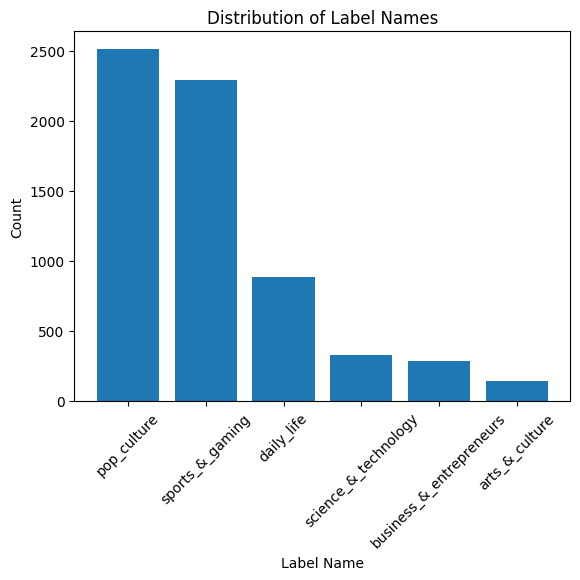

In [14]:
import matplotlib.pyplot as plt

# Get the value counts
value_counts = m_data['label_name'].value_counts()
print(value_counts)

# Create a bar chart
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Label Name')
plt.ylabel('Count')
plt.title('Distribution of Label Names')

# Rotate x-labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
import contractions

def fix(text):
    """
    This function fixes contractions in the input text bellow
    """
    return contractions.fix(text)


In [17]:

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Fix contractions
    text = fix(text)
    # Remove unnecessary punctuation
    text = re.sub(r'[^\w\s!?]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize words
    words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(words)

m_data['clean_text'] = m_data['text'].apply(clean_text)  

In [18]:
# Split data into features and target
X = m_data['clean_text']
y = m_data['label_name']

In [19]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Calculate class weights
class_weights = {cls: 1 / count for cls, count in m_data['label_name'].value_counts().items()}
print(class_weights)

{'pop_culture': 0.0003980891719745223, 'sports_&_gaming': 0.00043649061545176777, 'daily_life': 0.0011325028312570782, 'science_&_technology': 0.003067484662576687, 'business_&_entrepreneurs': 0.003484320557491289, 'arts_&_culture': 0.006944444444444444}


In [21]:
# Create a pipeline of vectorizer, transformer, and classifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(class_prior=list(class_weights.values())))
])

In [24]:
# Define hyperparameters to tune for MultinomialNB
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'clf__alpha': [0.01, 0.1, 1.0],
    'clf__fit_prior': [True, False],
    'clf__class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]],
    'clf__force_alpha': [True, False]
}

In [29]:
# Perform grid search to find the best combination of hyperparameters for MultinomialNB
grid_search = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultinomialNB(class_prior=[0.0003980891719745223,
                                                                   0.00043649061545176777,
                                                                   0.0011325028312570782,
                                                                   0.003067484662576687,
                                                                   0.003484320557491289,
                                                                   0.006944444444444444]))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'clf__class_prior': [None,
                                              [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]],
                         'clf__fit_prior': [True, False],
                         'clf__force_alpha': [True, False],
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

                          precision    recall  f1-score   support

          arts_&_culture       0.38      0.12      0.18        25
business_&_entrepreneurs       0.84      0.45      0.59        60
              daily_life       0.59      0.72      0.65       179
             pop_culture       0.85      0.80      0.83       497
    science_&_technology       0.65      0.58      0.61        60
         sports_&_gaming       0.84      0.92      0.88       468

                accuracy                           0.79      1289
               macro avg       0.69      0.60      0.62      1289
            weighted avg       0.79      0.79      0.79      1289



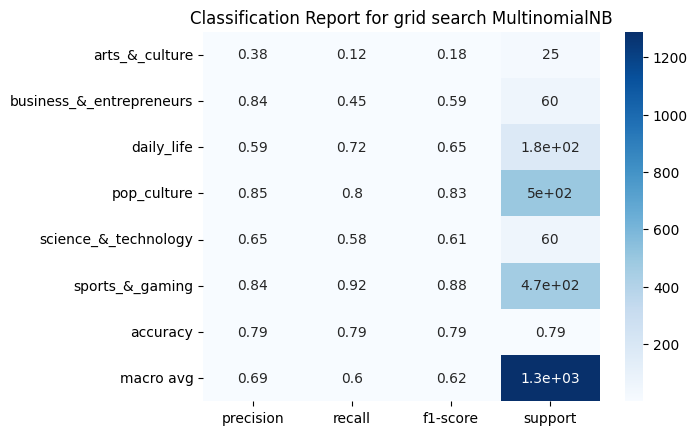

In [37]:
# Evaluate the grid search MultinomialNB on the test data
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

# Visualize the results as a heatmap
sns.heatmap(df.iloc[:-1, :].astype(float), annot=True, cmap='Blues')
plt.title('Classification Report for grid search MultinomialNB')
plt.show()

In [38]:
# Print the best hyperparameters for MultinomialNB
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'clf__alpha': 0.1, 'clf__class_prior': None, 'clf__fit_prior': False, 'clf__force_alpha': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [39]:
# Create a pipeline of TfidfVectorizer, transformer, and LinearSVC classifier
clf2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LinearSVC(C=1))
])

In [40]:
# Define hyperparameters to tune for LinearSVC
param_dist = {
    "clf__C": uniform(0, 10),
    "vect__max_features": [None, 1000, 10000],
    "vect__stop_words": [None, "english"],
}

In [41]:
# Perform grid search to find the best combination of hyperparameters for LinearSVC
clf2_rs = RandomizedSearchCV(clf2, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)
clf2_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('clf', LinearSVC(C=1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f290b1e5450>,
                                        'vect__max_features': [None, 1000,
                                                               10000],
                                        'vect__stop_words': [None, 'english']})

                          precision    recall  f1-score   support

          arts_&_culture       0.78      0.28      0.41        25
business_&_entrepreneurs       0.85      0.47      0.60        60
              daily_life       0.63      0.70      0.66       179
             pop_culture       0.86      0.86      0.86       497
    science_&_technology       0.73      0.62      0.67        60
         sports_&_gaming       0.86      0.93      0.89       468

                accuracy                           0.82      1289
               macro avg       0.78      0.64      0.68      1289
            weighted avg       0.82      0.82      0.81      1289



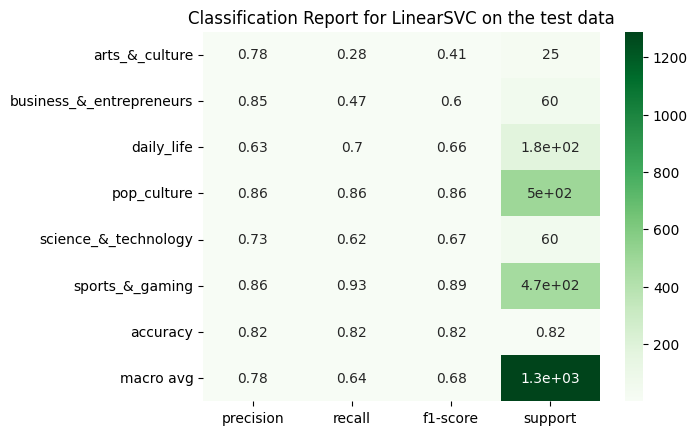

In [43]:
# Evaluate the grid search LinearSVC on the test data
y_pred = clf2_rs.predict(X_test)
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

# Visualize the results as a heatmap
sns.heatmap(df.iloc[:-1, :].astype(float), annot=True, cmap='Greens')
plt.title('Classification Report for LinearSVC on the test data')
plt.show()

In [45]:

# Print the best hyperparameters for LinearSVC
print("Best parameters: ", clf2_rs.best_params_)


Best parameters:  {'clf__C': 6.375879290612724, 'vect__max_features': None, 'vect__stop_words': None}


In [46]:
from sklearn.ensemble import VotingClassifier
#using best hyperparameters for MultinomialNB
clf1 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False, force_alpha=True))
])

clf2 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LinearSVC(C=1))
])
clf3 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha=1))
])
#using best hyperparameters for LinearSVC  
clf4 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words=None, max_features=None)),
    ('clf', LinearSVC(C=6.864347139857757))
])


# Combine the models using a voting classifier
voting_clf = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2), ('clf3', clf3), ('clf4', clf4)], voting='hard')
voting_clf.fit(X_train, y_train)




VotingClassifier(estimators=[('clf1',
                              Pipeline(steps=[('vect', CountVectorizer()),
                                              ('tfidf',
                                               TfidfTransformer(use_idf=False)),
                                              ('clf',
                                               MultinomialNB(alpha=0.1,
                                                             fit_prior=False,
                                                             force_alpha=True))])),
                             ('clf2',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('clf', LinearSVC(C=1))])),
                             ('clf3',
                              Pipeline(steps=[('vect',
                                               CountVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('tfidf',
                                               TfidfTransformer(use_idf=False)),
                                              ('clf',
                                               MultinomialNB(alpha=1))])),
                             ('clf4',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('clf',
                                               LinearSVC(C=6.864347139857757))]))])

                          precision    recall  f1-score   support

          arts_&_culture       0.80      0.16      0.27        25
business_&_entrepreneurs       0.88      0.47      0.61        60
              daily_life       0.63      0.69      0.66       179
             pop_culture       0.84      0.88      0.86       497
    science_&_technology       0.76      0.53      0.63        60
         sports_&_gaming       0.87      0.92      0.90       468

                accuracy                           0.82      1289
               macro avg       0.80      0.61      0.65      1289
            weighted avg       0.82      0.82      0.81      1289



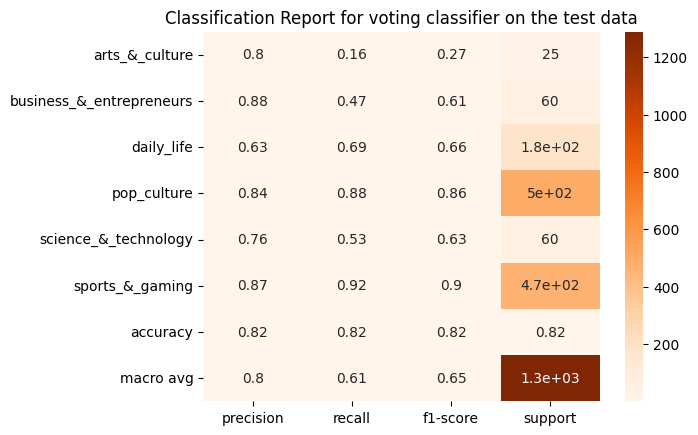

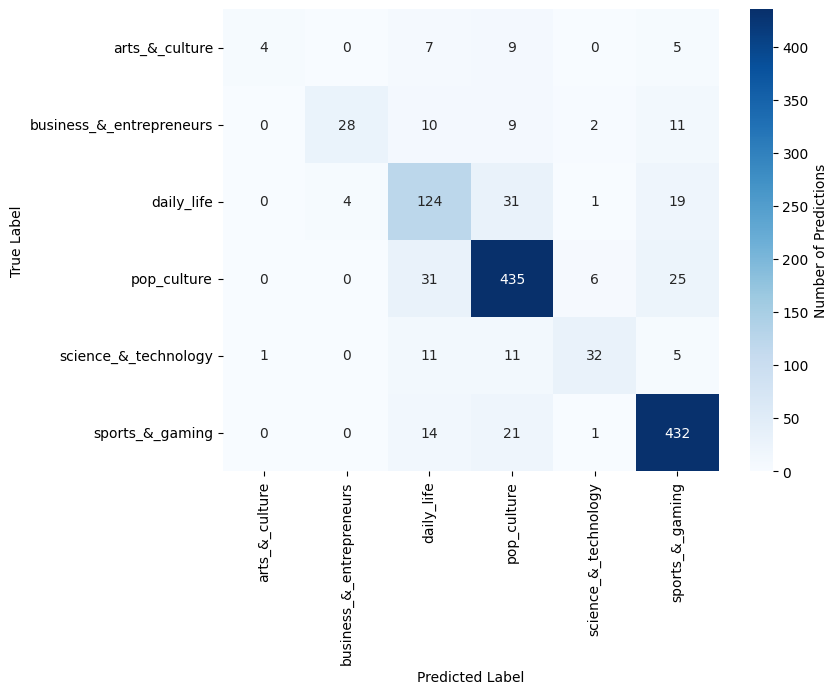

In [49]:
# Evaluate and visualize the ensemble on the test data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test set
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, labels=voting_clf.classes_))
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

# Visualize the results as a heatmap
sns.heatmap(df.iloc[:-1, :].astype(float), annot=True, cmap='Oranges')
plt.title('Classification Report for voting classifier on the test data')
plt.show()


# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=voting_clf.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', 
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_,
            cbar_kws={'label': 'Number of Predictions'})
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()



Prepare the model for Deployment

In [50]:
import joblib

# Saving the model to a file named twitter_classifier.joblib
filename = 'twitter_classifier.joblib'
joblib.dump(voting_clf, filename)


['twitter_classifier.joblib']

Deployment

In [51]:
#Deployment
# Load the model from file
filename = 'twitter_classifier.joblib'
clf = joblib.load(filename)


In [52]:
#Use the same function to preprocess new data

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Fix contractions
    text = fix(text)
    # Remove unnecessary punctuation
    text = re.sub(r'[^\w\s!?]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize words
    words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    processed_text = " ".join(words)
    
    return processed_text

In [53]:
#Collect new Twitter data and preprocess it using the same clean_text function
tweets = 'Anyone know why the #Dodgers #Orioles game' #the tweet is just an example of new dat
processed_tweets = clean_text(tweets)


In [54]:
#Use the loaded model to predict the class of the collected tweets
predicted_classes = clf.predict([processed_tweets])


                                        Tweet  Predicted Class
0  Anyone know why the #Dodgers #Orioles game  sports_&_gaming


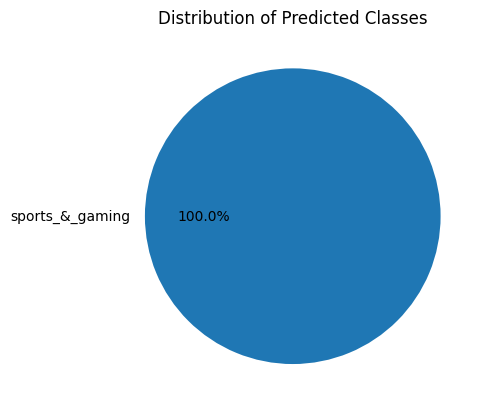

In [59]:
results = pd.DataFrame({'Tweet': tweets, 'Predicted Class': predicted_classes})
print(results)
#Also visualize the estimate
# Create a pie chart
plt.pie(counts, labels=classes, autopct='%1.1f%%')
plt.title('Distribution of Predicted Classes')
plt.show()
